# Aluno: Clésio de Araújo Gonçalves

# Regras de negócio

Esquema: Problema das 8 rainhas

Representação: Permutação

Recombinação: Cortar e completar os faltantes

Probabilidade de recombinação: 100%

Probabilidade de mutação: 80% (alta), pois a recombinação não gera indivíduos tão diferentes

Seleção dos pais: 2 melhores dos 5 selecionados aleatoriamente

Critério de sobrevivência: substituir o pior

Tamanho da população: 100

Número de descendentes: 2

Inicialização: Aleatória

Mutação: trocar 2 números de lugar

Condição de finalização: encontra a solução ou faz 10.000 avaliações de aptidão

# 1. Funções

In [1]:
import numpy as np
import pandas as pd
from itertools import permutations
from random import randint
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
n = 8  # Numero de rainhas
qnt_avaliacoes_aptidao = 0
populacao = pd.DataFrame(columns = ['linhas_xadrez', 'tabuleiros', 'qnt_xeque_mate'])
dois_melhores_pais, recombinacao, mutacao = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
solucao_encontrada = False

In [3]:
# Pega aleatoriamente 100 tabuleiros para a população inicial
def gera_populacao_inicial():

    # Gera as permutações com todas as possibilidades da matriz
    # A permutação atende as restrições em linhas e colunas (exceto diagonais)
    array = range(n)
    linhas_xadrez = list(permutations(array))
    
    dados = []

    for i in range(0,100):
        indice = randint(0, len(linhas_xadrez) - 1)
        dados.append(linhas_xadrez[indice])

    return dados

In [4]:
# Cria todos os tabuleiros de xadrez com as rainhas dispostas
def cria_tabuleiros(linhas_xadrez):

    # Variáveis locais
    tabuleiros = []
    indice_linha, indice_coluna = 0, 0

    # Gera a matriz xadrez
    matriz_xadrez = np.zeros((n, n), dtype=np.int32)

    for linha_xadrez in linhas_xadrez:
        for posicao_linha in linha_xadrez:
            matriz_xadrez[posicao_linha, indice_coluna] = 1
            indice_coluna += 1
        indice_coluna = 0
        tabuleiros.append(matriz_xadrez)
        matriz_xadrez = np.zeros((n, n), dtype=int)

    return tabuleiros

In [5]:
# Verifica a aptidão de uma lista de tabuleiros
def calcula_aptidao_tabuleiro(tabuleiros):

    # Variavel global
    global qnt_avaliacoes_aptidao
    
    # Variáveis locais
    qnt_xeque_mate, indice_linha, indice_coluna = 0, 0, 0
    lista_qnt_xeque_mate = []

    for tabuleiro in tabuleiros:
        for linha in tabuleiro:
            for elemento in linha:
                if (elemento == 1):  # Só verifica as posições do tabuleiro que possuem rainha
                    diagonal_principal = np.diagonal(tabuleiro, indice_coluna - indice_linha)
                    diagonal_secundaria = np.fliplr(tabuleiro).diagonal(((n - 1) - indice_coluna) - indice_linha)

                    # Se a rainha faz xeque mate na diagonal principal ou secundária
                    if sum(diagonal_principal) > 1 or sum(diagonal_secundaria) > 1:
                        qnt_xeque_mate += 1
                # Continua varrendo cada elemento da mesma linha
                indice_coluna += 1
            # Apos todos os elementos da linha, passa para a proxima linha
            indice_linha += 1
            indice_coluna = 0
        # Apos todas as linhas do tabuleiro, reinicia variavel para o proximo tabuleiro
        indice_linha = 0

        lista_qnt_xeque_mate.append(qnt_xeque_mate)
        qnt_xeque_mate = 0
        qnt_avaliacoes_aptidao += 1 # qnt avaliações aptidão

    return lista_qnt_xeque_mate

In [6]:
# Seleção dos pais: 2 melhores dos 5 selecionados aleatoriamente
def seleciona_dois_melhores_entre_cinco_pais(populacao):
    lista_cinco_indices = []

    # Seleciona aleatoriamente cinco pais
    for i in range(0, 5):
        indice = randint(0, len(populacao) - 1)
        lista_cinco_indices.append(indice)

    return populacao.iloc[lista_cinco_indices].sort_values(by = ['qnt_xeque_mate']).head(2)

In [7]:
# Recominação (crossover)
def recombinacao_dois_melhores_pais(dois_melhores_pais):
    
    linhas_xadrez = list(dois_melhores_pais['linhas_xadrez'])

    # crossover aleatório entre o indice 1 e 6 (não corta em 0 ou 7)
    corte = randint(1, (n - 2))
    
    parte1_pai1 = linhas_xadrez[0][:corte]
    parte2_pai1 = linhas_xadrez[0][corte:]
    
    parte1_pai2 = linhas_xadrez[1][:corte]
    parte2_pai2 = linhas_xadrez[1][corte:]
    
    # Add a parte 1 ao filho
    filho1 = list(parte1_pai1)
    filho2 = list(parte1_pai2)
    
    # Add a parte2 ao filho, desde que a parte2 não esteja presente na parte 1
    filho1 = filho1 + [i for i in parte2_pai2 if i not in filho1]
    filho2 = filho2 + [i for i in parte2_pai1 if i not in filho2]
    
    # Add ao filho os elementos restantes
    filho1 = filho1 + [i for i in range(0, n) if i not in filho1]
    filho2 = filho2 + [i for i in range(0, n) if i not in filho2]
    
    return filho1, filho2

In [8]:
def mutacao_dois_filhos(dois_filhos_recombinados):
    
    linhas_xadrez = dois_filhos_recombinados['linhas_xadrez']
    
    # Variavel global
    global qnt_avaliacoes_aptidao
    
    # mutação aleatória nos dois filhos (random entre 0 e 2)
    for i in range(0, 2):
        
        # Controle de 80% da mutação em cada filho
        controle_mutacao = randint(0, 4)
        
        # Se o controle de mutação for diferente de 4, então ocorre mutação
        if controle_mutacao != 4:
            indice1 = randint(0, (n - 1))
            indice2 = randint(0, (n - 1))
            linhas_xadrez[i] = list(linhas_xadrez[i])

            temp = linhas_xadrez[i][indice1]
            linhas_xadrez[i][indice1] = linhas_xadrez[i][indice2]
            linhas_xadrez[i][indice2] = temp
        else:
            # Mesmo que não ocorra mutação, irá verificar a aptidão de um tabuleiro que já foi verificado
            # Então decrementa a qnt_avaliacoes_aptidao em 1
            qnt_avaliacoes_aptidao -= 1
            
    return linhas_xadrez

In [9]:
def substituicao_populacao(dataset):
    
    # dataset população
    global populacao
    
    for i in range (0, 2):
        populacao_tail = populacao.sort_values(by = ['qnt_xeque_mate']).tail(1)
        dataset_head = dataset.sort_values(by = ['qnt_xeque_mate']).head(1)

        # Testa se maior qnt_xeque da população é menor que a menor que a qnt_xeque do dataset
        if (populacao_tail.qnt_xeque_mate.values[0] > dataset_head.qnt_xeque_mate.values[0]):
            populacao.linhas_xadrez.iloc[populacao_tail.index[0]] = dataset_head.linhas_xadrez.values[0]
            populacao.tabuleiros.iloc[populacao_tail.index[0]] = dataset_head.tabuleiros.values[0]
            populacao.qnt_xeque_mate.iloc[populacao_tail.index[0]] = dataset_head.qnt_xeque_mate.values[0]
        
        dataset.drop(dataset_head.index[0], inplace=True)

# 2. Inicialização da população

In [10]:
populacao['linhas_xadrez'] = gera_populacao_inicial()

In [11]:
populacao['tabuleiros'] = cria_tabuleiros(populacao['linhas_xadrez'])

In [12]:
populacao['qnt_xeque_mate'] = calcula_aptidao_tabuleiro(populacao['tabuleiros'])

In [13]:
populacao

,linhas_xadrez,tabuleiros,qnt_xeque_mate
0,"(2, 6, 1, 4, 7, 0, 3, 5)","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, ...",2
1,"(7, 1, 3, 6, 5, 4, 2, 0)","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, ...",6
2,"(4, 7, 1, 5, 3, 2, 6, 0)","[[0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, ...",6
3,"(0, 2, 6, 3, 1, 4, 5, 7)","[[1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, ...",5
4,"(7, 2, 5, 1, 6, 3, 0, 4)","[[0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, ...",4
...,...,...,...
95,"(4, 1, 5, 2, 3, 0, 7, 6)","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, ...",6
96,"(7, 0, 3, 4, 1, 2, 6, 5)","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, ...",7
97,"(1, 0, 4, 5, 2, 6, 7, 3)","[[0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, ...",7
98,"(7, 1, 2, 3, 0, 5, 4, 6)","[[0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...",6


In [14]:
# Verifica se a solução foi encontrada na inicialização da população
if len(populacao[populacao['qnt_xeque_mate'] == 0]) > 0:
    solucao_encontrada = True
    
    print("Solução encontrada na inicialização\n\n")
    tabuleiro = populacao.sort_values(by = ['qnt_xeque_mate']).tabuleiros.head(1)
    print(list(tabuleiro)[0])

# 3. Algoritmo evolucionário

In [15]:
while (solucao_encontrada == False) and (qnt_avaliacoes_aptidao <= 10000):
    
    # 3.1 Seleção dos dois melhores pais
    dois_melhores_pais = seleciona_dois_melhores_entre_cinco_pais(populacao)
    
    # 3.2 Recombinação dos dois melhores pais (100%)
    recombinacao['linhas_xadrez'] = recombinacao_dois_melhores_pais(dois_melhores_pais)
    recombinacao['tabuleiros'] = cria_tabuleiros(recombinacao['linhas_xadrez'])
    recombinacao['qnt_xeque_mate'] = calcula_aptidao_tabuleiro(recombinacao['tabuleiros'])
    
    # 3.3 Mutação (80%) - em cada um dos filhos
    mutacao['linhas_xadrez'] = mutacao_dois_filhos(recombinacao)
    mutacao['tabuleiros'] = cria_tabuleiros(mutacao['linhas_xadrez'])
    mutacao['qnt_xeque_mate'] = calcula_aptidao_tabuleiro(mutacao['tabuleiros'])
    
    # 3.4 Substitui o pior da população pelo melhor da mutacao/recombinação
    substituicao_populacao(mutacao)
    
    # Verifica se a solução foi encontrada
    if len(populacao[populacao['qnt_xeque_mate'] == 0]) > 0:
        solucao_encontrada = True
        print("Solução encontrada na %sª avaliação de aptidão" %(qnt_avaliacoes_aptidao))

if ((solucao_encontrada == False) and (qnt_avaliacoes_aptidao > 10000)):
    print("Solução não encontrada após %s avaliações de aptidão" %(qnt_avaliacoes_aptidao))

Solução encontrada na 390ª avaliação de aptidão


In [16]:
populacao.sort_values(by = ['qnt_xeque_mate'])

,linhas_xadrez,tabuleiros,qnt_xeque_mate
39,"[2, 5, 7, 1, 3, 0, 6, 4]","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, ...",0
0,"(2, 6, 1, 4, 7, 0, 3, 5)","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, ...",2
91,"[7, 4, 3, 0, 6, 1, 5, 2]","[[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, ...",2
56,"[2, 6, 1, 4, 7, 0, 3, 5]","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, ...",2
99,"[7, 1, 6, 4, 2, 0, 5, 3]","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, ...",2
...,...,...,...
64,"(6, 0, 7, 5, 1, 3, 2, 4)","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, ...",5
65,"[6, 5, 0, 3, 2, 4, 7, 1]","[[0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",5
24,"[2, 7, 1, 4, 6, 0, 5, 3]","[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, ...",5
70,"(4, 2, 7, 3, 0, 6, 5, 1)","[[0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",5


In [17]:
tabuleiro = populacao.sort_values(by = ['qnt_xeque_mate']).tabuleiros.head(1)
lista = list(tabuleiro)[0]
print(lista)

[[0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0]]


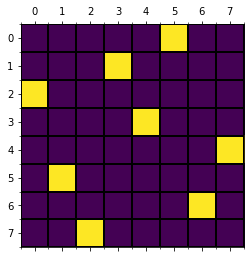

In [21]:
plt.matshow(lista)

ax = plt.gca();

ax.set_xticks(np.arange(-.5, n, 1), minor=True)
ax.set_yticks(np.arange(-.5, n, 1), minor=True)

ax.grid(which='minor', color='k', linestyle='-', linewidth=2)